<a href="https://colab.research.google.com/github/samantha-isaac/Emotion-Detection-in-Images-and-Music-Pairing-Through-AI/blob/main/CNN_FineTunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNNs Grid Search for the Face Expression Dataset

Samantha Isaac

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, Input, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import cv2
from google.colab import drive
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
import itertools

In [ ]:
# This is to mount Drive to this project
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Connect to My Drive
%cd /content/drive/My Drive/

/content/drive/My Drive


In [ ]:
# Paths to the folder for the Face expressions dataset
training_dataset_folder = '/content/drive/MyDrive/Dissertation/Code/Data_Faces/Training'
testing_dataset_folder = '/content/drive/MyDrive/Dissertation/Code/Data_Faces/Testing'

In [ ]:
# This function helps load the images and assigns as the labels the name of the correspodning folder
# References used for the function with os: https://docs.python.org/3/library/os.html
def load_images_and_labels(folder_path):
    images = []
    labels = []
    sub_folders = os.listdir(folder_path)

    for sub_folder in sub_folders:
        label = sub_folder  # In here is where the name of the sub folders is taken as the label
        image_files = os.listdir(os.path.join(folder_path, sub_folder))

        for image_file in image_files:
            image_path = os.path.join(folder_path, sub_folder, image_file)
            # This is to load the images in grey scale
            image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Reference for this: https://docs.opencv.org/4.x/d4/da8/group__imgcodecs.html
            if image is not None:
                images.append(image)
                labels.append(label)

    return images, labels

In [ ]:
# To load training images and labels
training_images, training_labels = load_images_and_labels(training_dataset_folder)

# To load testing images and labels
testing_images, testing_labels = load_images_and_labels(testing_dataset_folder)

Unique labels in the training set: {'Neutral', 'Happy', 'Sad', 'Fear', 'Angry'}
Unique labels in the test set: {'Neutral', 'Happy', 'Sad', 'Fear', 'Angry'}

Number of images per class in the training set:
Angry: 3995
Fear: 4097
Happy: 7215
Neutral: 4965
Sad: 4830

Number of images per class in the testing set:
Angry: 958
Fear: 1020
Happy: 1774
Neutral: 1233
Sad: 1247

Showing images of the class: Neutral

Showing images of the class: Happy

Showing images of the class: Sad

Showing images of the class: Fear

Showing images of the class: Angry

Showing images of the class: Neutral

Showing images of the class: Happy

Showing images of the class: Sad

Showing images of the class: Fear

Showing images of the class: Angry


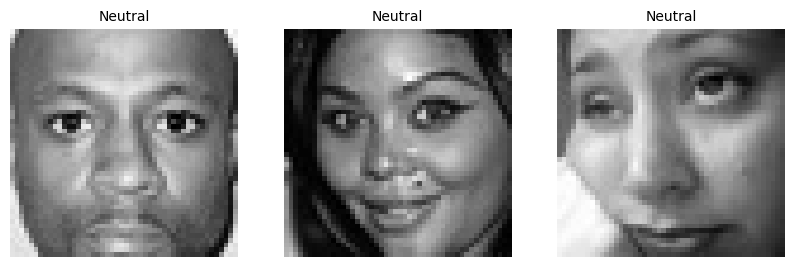

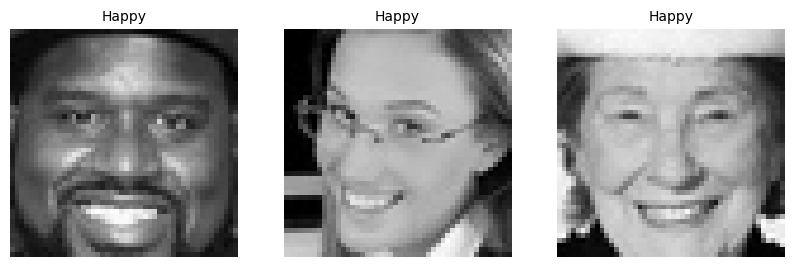

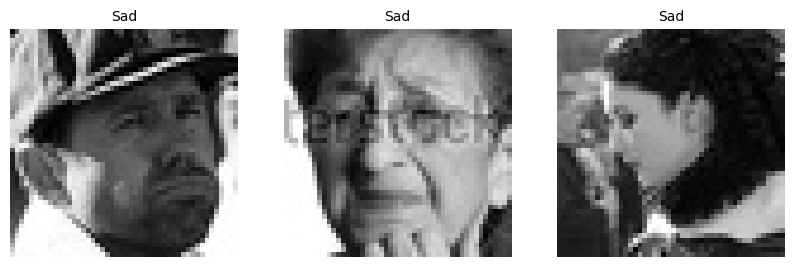

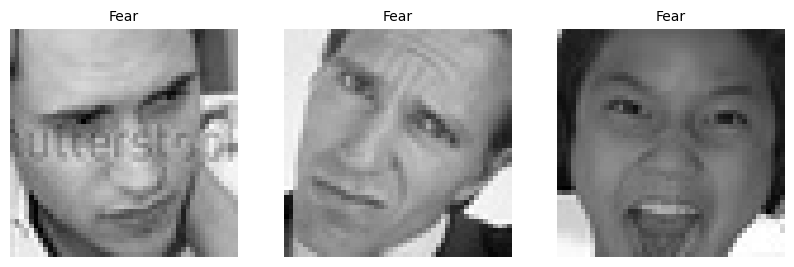

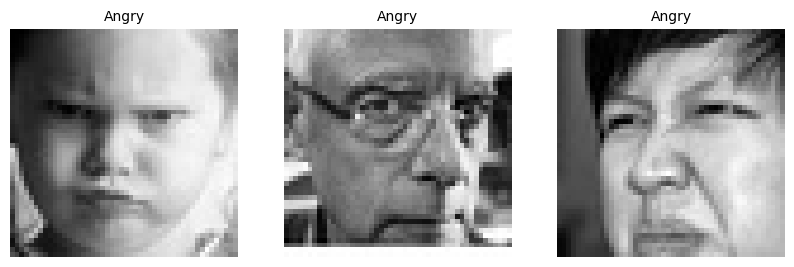

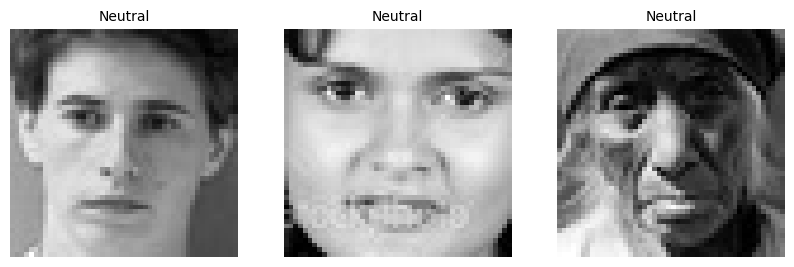

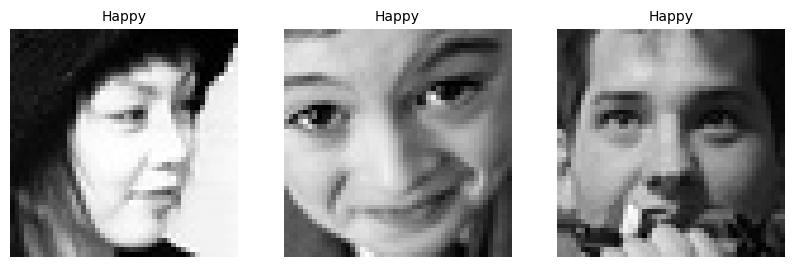

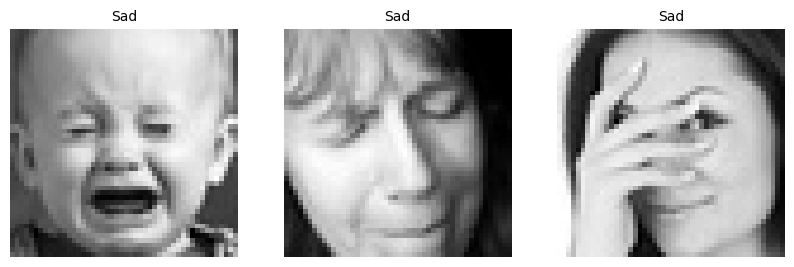

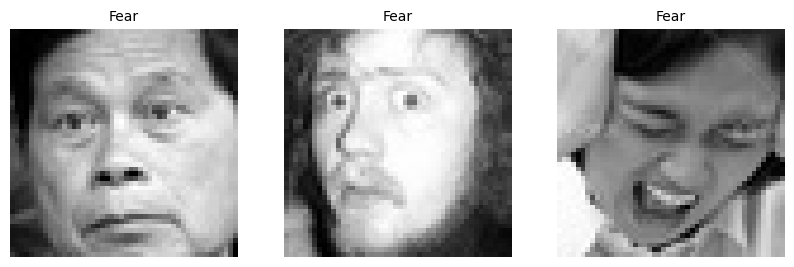

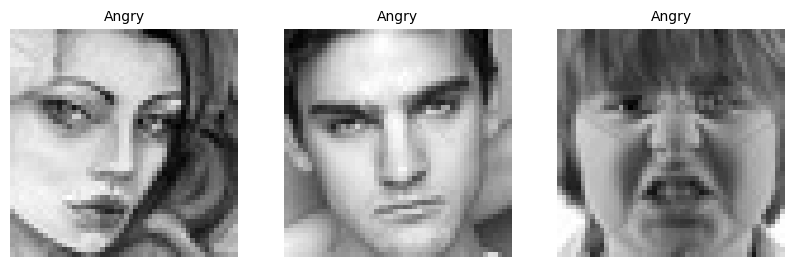

In [ ]:
# Convert tag lists into sets to view unique tags
training_labels_unique = set(training_labels)
testing_labels_unique = set(testing_labels)

# I print them to verify that the labels were properly assigned
print("Unique labels in the training set:", training_labels_unique)
print("Unique labels in the test set:", testing_labels_unique)

# To verify the total amount of images per label. Reference from: https://docs.python.org/3/library/collections.html#collections.Counter
training_labels_count = Counter(training_labels)
testing_labels_count = Counter(testing_labels)

print("\nNumber of images per class in the training set:")
for label, count in training_labels_count.items():
    print(f"{label}: {count}")

print("\nNumber of images per class in the testing set:")
for label, count in testing_labels_count.items():
    print(f"{label}: {count}")

# This is to show a few images to visually verify the images and the labels
def show_images_per_class(images, labels, clase, num_imagenes=3):
    print(f"\nShowing images of the class: {clase}") # This line was added to explicitatly indicate which images are being shown
    fig, axes = plt.subplots(1, num_imagenes, figsize = (10, 3)) # Reference from: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html
    # This is to create a list of the specific images
    imagenes_clase = [img for img, lbl in zip(images, labels) if lbl == clase]

# This is to iterate and take only the specific number of images, which is 3
    for i in range(num_imagenes):
        if i < len(imagenes_clase):
            axes[i].imshow(imagenes_clase[i], cmap = 'gray') # To show the images in grey scale
            axes[i].axis('off') # To hide the number and borders of the axis. Reference from: https://www.geeksforgeeks.org/how-to-turn-off-the-axes-for-subplots-in-matplotlib/
            # To add title with the corresponding label of each image
            axes[i].set_title(clase, fontsize = 10)
        else:
            axes[i].axis('off')

# It does this for both training and testing dataset
for label in training_labels_unique:
    show_images_per_class(training_images, training_labels, label)

for label in testing_labels_unique:
    show_images_per_class(testing_images, testing_labels, label)


In [ ]:
# Convert labels to numerical format
label_map = {label: idx for idx, label in enumerate(set(training_labels))}
training_labels_numeric = [label_map[label] for label in training_labels]
testing_labels_numeric = [label_map[label] for label in testing_labels]

In [ ]:
# Just to verify the labels with the index assigened to it
print("Contents of the label_map dictionary:")
print(label_map)

Contents of the label_map dictionary:
{'Neutral': 0, 'Happy': 1, 'Sad': 2, 'Fear': 3, 'Angry': 4}


In [ ]:
# Convert labels to one-hot encoding. Reference from: https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical
num_classes = len(label_map)
training_labels_y_encoded = to_categorical(training_labels_numeric, num_classes = num_classes)
testing_labels_y_encoded = to_categorical(testing_labels_numeric, num_classes = num_classes)

In [ ]:
# To normalize and to convert in arrays of NumPy. Reference from: https://numpy.org/doc/stable/reference/generated/numpy.array.html
training_images_x = np.array(training_images) / 255.0
testing_images_x = np.array(testing_images) / 255.0

In [ ]:
# This is to reshape images to add channel dimension. Reference: https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
training_images_x = training_images_x.reshape(-1, 48, 48, 1)
testing_images_x = testing_images_x.reshape(-1, 48, 48, 1)

In [ ]:
# This was an extra added to improve the generalisability of the model, generating new modified versions of the images
datagen = ImageDataGenerator(
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True
)

datagen.fit(training_images_x)

In [ ]:
# I stablish a function with the structure of the CNN model for the grid search.
# Used a reference for most of the structure of the models the project of: https://medium.com/@skillcate/emotion-detection-model-using-cnn-a-complete-guide-831db1421fael
def build_model(activation = 'relu', optimizer = 'adam', dropout_rate = 0.5, l2_rate = 0.001):
    input = Input(shape = (48, 48, 1))

    conv1 = Conv2D(32, (3, 3), padding='same', strides = (1, 1), kernel_regularizer = l2(l2_rate))(input)
    conv1 = Activation(activation)(conv1)
    conv1 = Dropout(dropout_rate)(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), padding = 'same', strides = (1, 1), kernel_regularizer = l2(l2_rate))(pool1)
    conv2 = Activation(activation)(conv2)
    conv2 = Dropout(dropout_rate)(conv2)
    pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), padding = 'same', strides = (1, 1), kernel_regularizer = l2(l2_rate))(pool2)
    conv3 = Activation(activation)(conv3)
    conv3 = Dropout(dropout_rate)(conv3)
    pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), padding = 'same', strides = (1, 1), kernel_regularizer = l2(l2_rate))(pool3)
    conv4 = Activation(activation)(conv4)
    conv4 = Dropout(dropout_rate)(conv4)
    pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

    flatten = Flatten()(pool4)
    dense_1 = Dense(128, activation = activation)(flatten)
    drop_1 = Dropout(dropout_rate)(dense_1)
    output = Dense(num_classes, activation = "softmax")(drop_1)

    model = Model(inputs = input, outputs = output)
    model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ['accuracy'])

    return model

In [ ]:
# Here I stablished the different values of the hyperparameters for the grid search
activation_functions = ['relu', 'leaky_relu']
optimizers = ['adam', 'rmsprop']
dropout_rates = [0.3, 0.4, 0.5]
l2_rates = [0.001, 0.0001]

In [ ]:
# This is for stablishing a combinations of hyperparameters. Reference: https://docs.python.org/3/library/itertools.html
hyperparameter_combinations = list(itertools.product(activation_functions, optimizers, dropout_rates, l2_rates))

# To create the training and testing sets
X_train, X_val, y_train, y_val = train_test_split(training_images_x, training_labels_y_encoded, test_size = 0.2, random_state = 42)

# This is to initialize variables to save the best combination
best_accuracy = 0
best_combination = None
best_model = None

In [ ]:
# This code genereates the grid search for the hyperparameters search with all the combinations
for activation, optimizer, dropout_rate, l2_rate in hyperparameter_combinations:
  # I print the values used in the corresponding iterations
    print(f"Testing with activation: {activation}, optimizer: {optimizer}, dropout_rate: {dropout_rate}, l2_rate: {l2_rate}")

    # In here I build and train the model
    model = build_model(activation = activation,
                        optimizer = optimizer,
                        dropout_rate = dropout_rate,
                        l2_rate = l2_rate)

# To train the model, and I specify the parameters to use. Reference: https://stackoverflow.com/questions/37973005/what-do-model-predict-and-model-fit-do
    history = model.fit(X_train, y_train,
                        validation_data = (X_val, y_val),
                        epochs = 50,
                        batch_size = 32,
                        verbose = 1)
# This is to extract the val_Accuracy to keep a record of the performance of the model
# Reference: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History
    val_accuracy = history.history['val_accuracy'][-1]

    # This is a simple way to save the best model and parameters
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        best_combination = (activation, optimizer, dropout_rate, l2_rate)
        best_model = model

print(f"Best accuracy: {best_accuracy} with parameters: {best_combination}")

Testing with activation: relu, optimizer: adam, dropout_rate: 0.3, l2_rate: 0.001
Epoch 1/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.2790 - loss: 1.6854 - val_accuracy: 0.2952 - val_loss: 1.5510
Epoch 2/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3344 - loss: 1.5343 - val_accuracy: 0.3846 - val_loss: 1.4996
Epoch 3/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.3909 - loss: 1.4570 - val_accuracy: 0.4202 - val_loss: 1.4567
Epoch 4/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4197 - loss: 1.4131 - val_accuracy: 0.4435 - val_loss: 1.4206
Epoch 5/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4348 - loss: 1.3812 - val_accuracy: 0.4527 - val_loss: 1.3807
Epoch 6/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4526 - loss: 1.3506 - val_accuracy: 0.4469 - val_loss: 1.3865
Epoch 7/50
628/628 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4672 - loss: 1.3233 - val_accuracy: 0.4648 - val_loss: 1.3451
Epoch 8/50
628/628 ━

In [ ]:
# This is to evaluate as well the performance of the model with a confusion matrix and a clasification report
# This is for the model to make prediction on the testing images. Reference: https://www.tensorflow.org/api_docs/python/tf/keras/Model
y_pred = best_model.predict(testing_images_x)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(testing_labels_y_encoded, axis = 1)

195/195 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


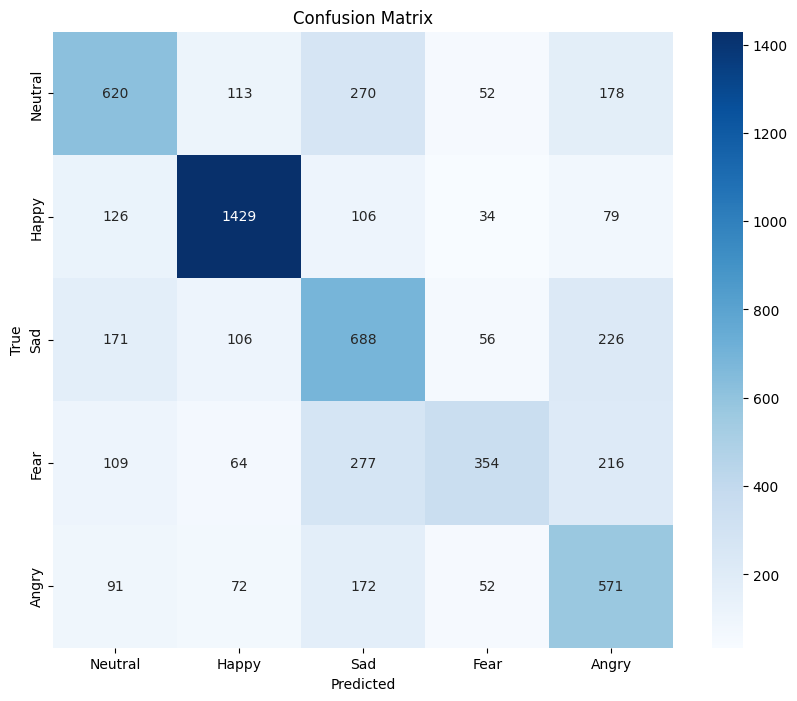

Classification Report:
              precision    recall  f1-score   support

     Neutral       0.56      0.50      0.53      1233
       Happy       0.80      0.81      0.80      1774
         Sad       0.45      0.55      0.50      1247
        Fear       0.65      0.35      0.45      1020
       Angry       0.45      0.60      0.51       958

    accuracy                           0.59      6232
   macro avg       0.58      0.56      0.56      6232
weighted avg       0.60      0.59      0.59      6232



In [ ]:
# This is for the confusion matrix. Reference: https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize = (10, 8))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = label_map.keys(), yticklabels = label_map.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Show classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=label_map.keys()))